**This is the summary notebook about the:**

- overall approach
- key findings
- assumptions/ limitations/ difficulties

**Which contains these main sections:**

1. analyzing possible relationship between features
2. linear predicting rental price
3. random forest predicting rental price
4. geo visualization on routes of properties with highest/ lowest rental price
5. finding most liveable suburbs
6. finding most affordable suburb suburbs
7. assumption/ limitations/ difficulties


In [30]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import metrics
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import os
import webbrowser
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split

### Section 1: analyzing

In [31]:

# read data about all properties from Domain website
df=pd.read_csv('../data/curated/property_full.csv')

# remove feature wouldn't be useful towards model training
df=df.drop(columns=['Unnamed: 0','Unnamed: 0_x','Unnamed: 0.1','name','coordinates','closest_school_name','closest_school_coor',
'closest_sc_name','closest_sc_coor','closest_station_coor','2001population','2002population', '2003population', 
'2004population', '2005population', '2006population', '2007population', '2008population', '2009population',
'2010population', '2011population', '2012population', '2013population','2014population', '2015population', 
'2016population', '2017population', '2018population', '2019population', '2020population',
'2014-15 MEDIAN EMPLOYMENT INCOME PER JOB', '2015-16 MEDIAN EMPLOYMENT INCOME PER JOB',
'2016-17 MEDIAN EMPLOYMENT INCOME PER JOB', '2017-18 MEDIAN EMPLOYMENT INCOME PER JOB',
'2011_unemploy_rate', '2012_unemploy_rate', '2013_unemploy_rate', '2014_unemploy_rate',
'2015_unemploy_rate', '2016_unemploy_rate', '2017_unemploy_rate', '2018_unemploy_rate', '2019_unemploy_rate', 
'2020_unemploy_rate', '2014-15 #jobs*000', '2015-16 #jobs*000', '2016-17 #jobs*000', '2017-18 #jobs*000',])

# change all numeric feature to numeric data type
cols = ['cost_text', 'rooms', 'baths', 'parking', 'driving_time_to_school',
       'distance_to_school', 'driving_time_to_CBD', 'distance_to_CBD',
       'driving_time_to_sc', 'distance_to_sc', 'driving_time_to_station',
       'distance_to_station', 'SA2_code', '2021population',
       '2011-2021no', '2011-2021%', 'Area', 'Population density 2021',
       '2018-19 #jobs*000', '2018-19 MEDIAN EMPLOYMENT INCOME PER JOB',
       '2021_unemploy_rate']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# rename the features
df = df.rename(columns={'2021population':'population_21','2011-2021no':'num_increase',
'2011-2021%':'percent_increase','Population density 2021':'pop_dens_21','2018-19 #jobs*000':'num_job_19',
'2018-19 MEDIAN EMPLOYMENT INCOME PER JOB':'income_rate_19','2021_unemploy_rate':'unemployment_rate_21'})

#calculating the lower and upper limit for mean +- 1.5IQR for rent price
lower = df["cost_text"].quantile(0.25) - 1.5*(df["cost_text"].quantile(0.75)-df["cost_text"].quantile(0.25))
upper = df["cost_text"].quantile(0.75) + 1.5*(df["cost_text"].quantile(0.75)-df["cost_text"].quantile(0.25))
#remove instance which has trip time outside the 1.5IQR range from mean
df = df[(df["cost_text"]>lower) & (df["cost_text"]<upper)]


<AxesSubplot:>

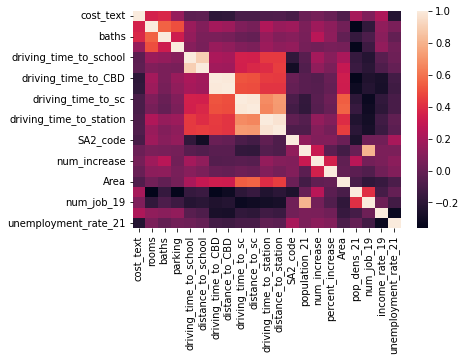

In [32]:
# create heatmap to visualize if there's any linear relationship
sns.heatmap(df.corr())


In [33]:
# by visualising the correlation between features with heatmap, 
# we can see that there are some features such as number of rooms and baths 
# which are shown to have some significant linear relationship with rental price.
# So we assume the features we chose have a linear relationship with the rental 
# price and use linear regression.

# pairplots between the rental price and features are also created, but didn't see
# any significant trends 

### Section 2: linear regression predicting rental price

In [34]:
# after doing some feature selection with stepwise selection
# this is the final linear model that we decided to use, with relavent features selected
fit3=ols(
    formula="cost_text ~ rooms + baths + parking + distance_to_CBD + distance_to_sc +\
        population_21 + num_increase + percent_increase + Area +\
        pop_dens_21 + num_job_19 + income_rate_19 + unemployment_rate_21 + C(SA2_code)",
    data=df
).fit()
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:              cost_text   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     40.71
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:00:20   Log-Likelihood:                -54938.
No. Observations:                9518   AIC:                         1.106e+05
Df Residuals:                    9138   BIC:                         1.134e+05
Df Model:                         379                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

So the final features are:

number of rooms   
number of bath  
number of parking  
distance to CBD  
distance to closest shopping center  
suburb of property  
 
population  
population increase in last 10 years  
population percentage increase in last 10 years  
suburb area size  
population density  
number of jobs  
median income rate  
unemployment rate  


In order to predict future rental prices of different suburbs, 
for features such as number of rooms, baths of properties, 
we find their average based on their suburb. 
for features such as population increase in the last 10 years for the suburb, 
we assume that they wouldn’t change much after a few years of time. 
For some other features such as population, income which varies as time changes, 
we predicted their future value based on previous data.




In [35]:
# find the mean of all features based on SA2 code, the average of internal features such as cost, 
# rooms and bath of each property will be used to predict suburb rent price

df1=df.groupby('SA2_code').mean()

# remove the first row where the sa2 code is out of range
df1=df1.iloc[1:,:]

# rest the index of the dataframe
df1=df1.reset_index()

# take out the features that will be used to predict suburb rent price
df1=df1[['SA2_code', 'rooms', 'baths', 'parking', 'distance_to_CBD', 'distance_to_sc', 
       'num_increase', 'percent_increase', 'Area', 'pop_dens_21']]

df1=df1.rename(columns={'SA2_code':'SA2'})

# read prediction of number of jobs, median income rate, unemployment rate, and population
# based on sa2 suburbs
income_num=pd.read_csv('../data/curated/income_num_predict.csv')
income_rate=pd.read_csv('../data/curated/income_rate_predict.csv')
unemployment=pd.read_csv('../data/curated/unemployment_predict.csv')
population=pd.read_csv('../data/curated/population_predict.csv')

unemployment=unemployment.rename(columns={'SA2 Code (2016 ASGS)':'SA2'})
population=population.rename(columns={'SA2 code':'SA2'})

# join the dataset together
df2=pd.merge(df1,income_num[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'num_job_19'})
df2=pd.merge(df2,income_rate[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'income_rate_19'})
df2=pd.merge(df2,unemployment[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'unemployment_rate_21'})
df2=pd.merge(df2,population[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'population_21'})
df2=df2.rename(columns={'SA2':'SA2_code'})

# find list of all unique sa2 code
df3=df2['SA2_code']

# add the suburb name of these sa2 code
df3=pd.merge(df3,df[['SA2_name', 'SA2_code']],on='SA2_code',how='left')
df3=df3.drop_duplicates()
df3=df3.reset_index()
df3=df3.iloc[:,1:]

# get 2025 data
df2=pd.merge(df1,income_num[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'num_job_19'})
df2=pd.merge(df2,income_rate[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'income_rate_19'})
df2=pd.merge(df2,unemployment[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'unemployment_rate_21'})
df2=pd.merge(df2,population[['SA2','2025']],on='SA2')
df2=df2.rename(columns={'2025':'population_21'})
df2=df2.rename(columns={'SA2':'SA2_code'})

# predict rent price of each sa2 suburb 
df3['2025']=fit3.predict(df2)

# create new dataframe to store predictions, add the average rent of this year for each suburb
df1=df.groupby('SA2_code').mean().reset_index()

df4=pd.merge(df3,df1,on='SA2_code',how='left')

# calculate increase in rent each year
df4['25dif']=df4['2025']-df4['cost_text']
# calculate how much the rent increase for each suburb by percentage
df4['25rate']=((df4['2025']-df4['cost_text'])/df4['cost_text'])*100

# 2025 top 11 suburb with highest rent increasing by rate(percentage)
df4.sort_values('25rate',ascending=False).head(11)[['SA2_name','25rate']]

,SA2_name,25rate
267,Laverton,14.658151
182,Campbellfield - Coolaroo,13.134962
318,Otway,9.428457
9,Maryborough (Vic.),8.371319
315,Colac,6.904570
256,Braybrook,6.138311
312,Portland,5.709543
316,Colac Surrounds,5.021446
4,Wendouree - Miners Rest,4.977385
7,Daylesford,4.939806


Combining the 3 types of features, we predicted the rental price of each suburb for the next 3 years with linear regression and calculated the rate of their rental price increase. And the final result for the top 10 suburbs with the highest predicted rental price growth rate are: Laverton, Coolaroo, Otway, Maryborough, Colac, Braybrook, Portland, Wendouree, Daylesford, and Ballarat.

### Section 3:  random forest predicting rental price

In [38]:
df=df.dropna()

In [39]:
#use the random forest model to predict the future rental prices in VIC until 2025
#use this model to predict three times to get the result of the rental price of 2025
X=df[['rooms', 'baths', 'parking', 'driving_time_to_school',
       'distance_to_school', 'driving_time_to_CBD', 'distance_to_CBD',
       'driving_time_to_sc', 'distance_to_sc', 'driving_time_to_station',
       'distance_to_station', 'SA2_code', 'population_21', 'num_increase',
       'percent_increase', 'Area', 'pop_dens_21', 'num_job_19',
       'income_rate_19', 'unemployment_rate_21']]
y=df['cost_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg_rf=RandomForestRegressor(verbose=0,n_jobs=8,random_state=42)
reg_rf.fit(X_train,y_train)
y_predict_rf = reg_rf.predict(X_test)

In [40]:
#calculate the Mean Absolute Error, Root Mean Squared Error, R-square to evaluate if the model prediction is accurate.
from sklearn import metrics
import numpy as np
print("Randomforest Evaluation")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rf)))
print('R-square:', r2_score(y_test,y_predict_rf))

Randomforest Evaluation
Mean Absolute Error: 53.28775468680689
Mean Squared Error: 5371.339922974662
Root Mean Squared Error: 73.28942572414292
R-square: 0.6745710904929996


In [41]:
#get the data of rental prices from 2022 to 2025
df1= pd.read_csv('../data/curated/rfmodel.csv')
df1

FileNotFoundError: [Errno 2] No such file or directory: '../data/curated/rfmodel.csv'

In [ ]:
#calculate the increase rate from 2022 to 2025
df1['to25rate']=((df1['2025']-df1['cost_text'])/df1['cost_text'])*100
df1

,SA2_code,cost_text,2023,2024,2025,SA2_name,to25rate
0,201011002.0,413.472222,409.569857,414.461089,417.814154,Ballarat,1.050114
1,201011005.0,432.857143,439.878571,442.168983,443.553587,Buninyong,2.471126
2,201011006.0,452.948718,459.368497,458.016846,456.810066,Delacombe,0.852491
3,201011008.0,373.695652,402.642935,408.168429,412.389512,Wendouree - Miners Rest,10.354378
4,201021009.0,385.000000,451.125000,465.440034,473.461903,Bacchus Marsh Surrounds,22.977118
...,...,...,...,...,...,...,...
369,217031476.0,325.555556,348.288889,346.406778,347.499392,Otway,6.740428
370,217041477.0,420.000000,445.862500,450.498000,451.515434,Moyne - East,7.503675
371,217041478.0,376.000000,431.878000,421.814518,417.285935,Moyne - West,10.980302
372,217041479.0,399.736842,396.784298,394.386486,391.966645,Warrnambool - North,-1.943828


In [ ]:
# 2025 top 10 suburb with highest rent increasing by rate(percentage)
df1.sort_values('to25rate',ascending=False).head(10)[['SA2_name','to25rate']]

,SA2_name,to25rate
245,Yarra Valley,106.175595
341,Mildura Surrounds,56.137682
57,Yackandandah,53.945878
17,Bendigo Surrounds - South,44.389849
338,West Wimmera,38.558883
335,Nhill Region,31.752063
168,Kinglake,27.746206
68,Leongatha,24.093230
4,Bacchus Marsh Surrounds,22.977118
354,Moira,20.950160


We find that no matter the Mean Absolute Error, nor the Mean Squared Error, both of them are too large which means that the residuals between the predicted points and the actual points are too large, and it is bad for this model. Then, I also observed that the R2 score is the negative number which means that the model fits not very well, and the predicted points are not good enough, even though the mean value is better than the predicted points. 

Finally, our group decided to pick up the linear regression model.


### Section 4: geo visualization

We visualise the location of 30 most expensive and cheapest properties and their routes to CBD, closest school, shopping centre and train station.

Interestingly, we found that many cheapest properties are concentrated around the centre of the Melbourne CBD. We assume that it is because the properties leased in the CBD are mostly apartments which have less room compared to other properties. 

For the routes from properties and schools, it seems that for each property, no matter how much its rental price is, it’s always close to its nearest school. We are delighted to see these results since it demonstrates a very completed and adequate education construction in each suburb. 

Properties that are around the CBD regardless of rental price are closer to shopping centres and train stations due to the relatively greater density of construction of infrastructures. 

In [ ]:
# visualise route to CBD
file = '/plots/cbd_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

In [ ]:
# visualise route to closest schools
file = '/plots/school_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

In [ ]:
# visualise route to closest shopping centre
file = '/plots/shop_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

In [ ]:
# visualise route to closest train station
file = '/plots/station_route.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

### Section 5: finding most liveable suburb

For the livability metrics of suburbs, the main features that we haven chosen are the distances from closest school, cbd, shopping centre, and train station to every property. This is because these four places are all public facilities, and if a property is close to them, it means the daily life of the person who lives in it is convenient.

In order to find livability ranking, for each property, and each of their selected features, we rank them out of all properties. The higher ranking reveals a smaller distance. We consider the smaller ranking number will be better to show livability. 
We then sum up the ranking of each property for different features, and create a new livability rank for each property with it.

As a result, the top 5 suburbs that’re most liveable are South Yarra - North, Flemington, Melbourne CBD - West ,Northcote - West, and West Melbourne.


**Livability formula**

$$
Property \quad livability \quad rank = rank(distance \quad to \quad CBD) \\
+ rank(distance \quad to \quad closest \quad school) \\
+ rank(distance \quad to \quad closest \quad shopping \quad centre) \\
+ rank(distance \quad to \quad closest \quad train \quad station)
$$


$$
Suburb \quad livability \quad rank = average(all \quad property \quad livability \quad rank \quad for \quad properties \quad in \quad that \quad suburb)
$$

In [ ]:
df = pd.read_csv('../data/curated/livable_suburb_2_top_20.csv')
df

,SA2_name,rank_avg
0,South Yarra - North,11.25
1,Flemington,22.50
2,Melbourne CBD - West,23.50
3,Northcote - West,26.75
4,West Melbourne - Residential,28.00
5,Brunswick - South,28.75
6,Flemington Racecourse,30.25
7,Hawthorn - South,31.50
8,Melbourne CBD - East,31.50
9,Hawthorn East,33.25


In [ ]:
file = '/plots/livable_rank.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)


### Section 6: finding most affordable suburb

For affordability, we found that some suburbs actually have a high rental price but with a relatively low rental price per room because some suburbs are mainly constituted with houses which have more rooms than apartments. Therefore, we decided to use rental price per room as our affordability metrics.

So for each property, we calculated the rental price per room by dividing the rent price with the number of rooms, and based on the suburb the property located, we grouped all their rental prices per room, found their average, and ranked the affordability based on this value.

As a result, the top 5 suburbs that’re most affordable are Yarra Valley, Mildura Surrounds, West Wimmera,Bendigo South, and Yackandandah.


In [ ]:
df = pd.read_csv('../data/curated/affordable_suburb_top_20.csv')
df

,SA2_name,Rent
0,Yarra Valley,66.666667
1,Mildura Surrounds,73.333333
2,West Wimmera,76.666667
3,Bendigo Surrounds - South,80.000000
4,Yackandandah,95.000000
5,Kerang,96.111111
6,Yarriambiack,99.583333
7,Corangamite - North,103.333333
8,Melton South - Weir Views,107.165385
9,Wyndham Vale - South,108.314815


In [ ]:
file = '/plots/mean_rent.html'
filepath = os.path.abspath(os.path.join(os.path.dirname("__file__"),os.path.pardir))
file_uri = 'file:///' + filepath + file
webbrowser.open_new_tab(file_uri)

### Section 7: assumptions/ limitations/ difficulties

**assumptions:**

for the property data we gain from the Domain website, we assume the properties data obtained from the Domain website is realistic which is a good sample of rent properties.

we assume the features we chose have a linear relationship with the rental price and use linear regression.

for features such as population increase in the last 10 years for the suburb, we assume that they wouldn’t change much after a few years of time. 

We assume the liveability and affordability metrics we have chosen are suitable and workable metrics for liveability and affordability

**limitations & difficulty:**

There are also some limitation and difficulties for our project

Since one of the goals for this project is to predict future suburb rental prices, having historical rental prices would definitely help in predicting the future.

Also, the lack of statistics from income, unemployment rate for a few recent years since ABS has not released those data yet.

The size of our data is also limited to about 15,000 property data, since currently we only obtain data from the Domain website, exploring other data source would help to expand the data size

Meanwhile, Open route service provides one free accessed api for each registered account with a limitation of calling. We have used Directions which has a limit of 2000 quotas per day and 40 quotas per minute, and Matrix which has a limit of 500 quotas per day and 40 per minute. So to find a different route for all properties, we have to change to a different Api key after one reaches the limit.
